# Build a recommendation system with TensorFlow and Keras




A recommendation system ia a system that gives a `query (context)` which is what we know about the liking list, and filter the corpus (full catalog of items) to a shortlist of `candidates` (items, documents). A query (context) can be a combination of ***user id***, ***user's geographical location***, ***user's history of previous purchases***, etc and the resulting candidates can be some new items that we guess are interesting for the user.

The query can also be a combination of ***item id***, ***its image***, ***its textual description***, etc and the candidates can be some similar or related items from the corpus.
<p>&nbsp;</p>
<p align="center">
  <img width="556" height="82" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/recsys_io.png">
</p>
<p>&nbsp;</p>

### Recommendation stages (tasks)
In practice, dealing with a large corpus and filter it to a shortlist is an intractable and inefficient task. So practical recommender systems has two (or three) filterng phases:
1. Retrieval (Candidate Generation)
2. Ranking (Scoring)
3. Re-ranking or optimazation or ...

<p align="center">
  <img width="700" height="394" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/retrieval_ranking.png">
</p>

<p align="center">
  <img width="700" height="394" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/deepmind_forgoogle_recsys.png">
</p>

### Content-based Filtering vs Collaborative Filtering
Filtering items is based on similarities. we can filter the list based on similar candidates (`content-based filtering`) or based on the similarity between queries and candidates (`collaborative filtering`). Collaborative filtering algorithms usually perform better than content-based methods.

<p align="center">
  <img width="700" height="330" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/cbf_cf.png">
</p>

### Representation of a query or a candidate
A query or a candidate has lots of different features. For example a query can be constructed by these features:
- user_id
- user_previous_history
- user_job
- etc.

And a candidate can have features like:
- item_description
- item_image
- item_price
- posted_time
- etc.

These obviouse features can be `numerical variables`, `categorical variables`, `bitmaps` or `raw texts`. However, these low-level features are not enough for any prediction and we should extract some more abstract `latent features` from these obvious features to represent the query or the candidate as a numerical high-dimensional vector - known as `Embedding Vector`.

`Matrix Factorization` (MF) is a classic collaborative filtering method to learn some `latent factors` (latent features) from `user_id`, `item_id` and `rating` features and represent **users** and **items** by latent (embedding) vectors.

<p align="center">
  <img width="826" height="398" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/mf.png">
</p>

Matrix Factorization method only uses `user_id` and `candidate_id` features collaboratively to learn the `latent features`. In fact it doesn't care about other side-features like `candidate_description`, `price`, `user_comment`, etc.

To involve side-features as well as ids while learning latent features (embeddings), we can use deep neural network (DNN) architectures like `softmax` or `two-tower` neural models.

<p align="center">
  <img width="540" height="340" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/tensorflow_two_tower.gif">
</p>

YouTube two-tower neural model uses side-features to represent queries and candidates in an abstract high-dimentional embedding vector.

<p align="center">
  <img width="540" height="340" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/youtube_retrieval.png">
</p>

### Movielens dataset

The `Movielens` dataset is a benchmark dataset in the field of recommender system research containing a set of *ratings* given to *movies* by a set of *users*, collected from the [MovieLens website](http://movielens.org/) - a movie recommendation service.

There are 5 different versions of Movielens available for different purposes: "25m", "latest-small", "100k", "1m" and "20m". In this tutorial we are going to work with "100k" version. 
**movielens/100k-ratings**

The oldest version of the MovieLens dataset containing 100,000 ratings from 943 users on 1,682 movies. Each user has rated at least 20 movies. Ratings are in whole-star increments. This dataset contains demographic data of users in addition to data on movies and ratings.

**movielens/100k-movies**

This dataset contains data of 1,682 movies rated in the ***movielens/100k-ratings*** dataset.

## Make an input pipeline with TensorFlow Datasets
TensorFlow Datasets ([TFDS library](https://www.tensorflow.org/datasets/overview)) provides a collection of ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks.

It handles downloading and preparing the data deterministically and constructing a `tf.data.Dataset` (or `np.array`) in order to enabling easy-to-use and high-performance input pipelines.

In [1]:
# Make sure the latest version of TFDS library is installed.
# Older versions are not supported here.
!pip install -q --upgrade tensorflow-datasets
 
import tensorflow_datasets as tfds

     |████████████████████████████████| 3.7MB 5.9MB/s 


In [2]:
# Download the data, save them as `tfrecord` files, load the `tfrecord` files
# and create the `tf.data.Dataset` object containing the dataset.
ratings_dataset, ratings_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    # MovieLens dataset is not splitted into `train` and `test` sets by default.
    # So TFDS has put it all into `train` split. We load it completely and split
    # it manually.
    split='train',
    # `with_info=True` makes the `load` function return a `tfds.core.DatasetInfo`
    # object containing dataset metadata like version, description, homepage,
    # citation, etc.
    with_info=True
)

# Calling the `tfds.load()` function in old versions of TFDS won't return an
# instance of `tf.data.Dataset` type. So we can make sure about it.
import tensorflow as tf
assert isinstance(ratings_dataset, tf.data.Dataset)

print(
    "ratings_dataset size: %d" % ratings_dataset.__len__()
)

# Use `tfds.as_dataframe()` to convert `tf.data.Dataset` to `pandas.DataFrame`.
# Add the `tfds.core.DatasetInfo` as second argument of `tfds.as_dataframe` to
# visualize images, audio, texts, videos, etc. `pandas.DataFrame` will load the
# full dataset in-memory, and can be very expensive to display. So use it only
# with take() function.
print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

## Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

## Split dataset randomly (80% for train and 20% for test)
trainset_size = 0.8 * ratings_dataset.__len__().numpy()
# In an industrial recommender system, this would most likely be done by time:
# The data up to time T would be used to predict interactions after T.

# set the global seed:
tf.random.set_seed(42)
# More info: https://www.tensorflow.org/api_docs/python/tf/random/set_seed

# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # the new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size=100_000,
    # set the random seed that will be used to create the distribution.
    seed=42,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration=False
)
# More info: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
 
ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

print(
    "ratings_trainset size: %d" % ratings_trainset.__len__()
)
print(
    "ratings_testset size: %d" % ratings_testset.__len__()
)

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.
ratings_dataset size: 100000
   bucketized_user_age movie_genres  ... user_rating user_zip_code
0                 45.0          [7]  ...         4.0      b'53211'
1                 25.0      [4, 14]  ...         2.0      b'80525'
2                 18.0          [4]  ...         4.0      b'55439'
3                 50.0       [5, 7]  ...         4.0      b'06472'
4                 50.0     [10, 16]  ...         3.0      b'75094'

[5 rows x 12 columns]
  movie_id                                movie_title  ...  user_id user_rating
0   b'357'  b"One Flew Over the Cuckoo's Nest (1975)"  ...   b'138'         4.0
1   b'709'                b'Strictly Ballroom (1992)'  ...    b'92'         2.0
2   b'412'             b'Very Brady Sequel, A (1996)'  ...   b'301'         4.0
3    b'56'                     b'Pulp Fiction (1994)'  ...    b'60'         4.0
4   b'

## Preprocess raw features and make embeddings with Keras preprocessing layers

Raw features are usually not be immediately usable in a machine learning model and should be preprocessed in the first place.
- **Numerical features** (ratings, prices, timestamps, etc) can be far away in terms of scale and need to be `normalized` so that their values lie in a small interval around 0.
- **Categorical features** (ids, usernames/emails, titles, etc) are usually string features and have to be translated into `embedding vectors` (numerical feature representations) that are adjusted during training the model.
- **Text features** (descriptions, comments, etc) need to be at first, `tokenized` (split into smaller parts such as individual words known as word pieces) and then translated into embeddings.

[Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/) let us build `end-to-end` portable models that accept raw features (raw images or raw structured data) as input; models that handle feature normalization or feature value indexing on their own.

Let's first have a look at what features we can use from the MovieLens dataset:


In [3]:
from pprint import pprint

for rating in ratings_trainset.take(1).as_numpy_iterator():
  pprint(rating)

{'movie_id': b'898',
 'movie_title': b'Postman, The (1997)',
 'timestamp': 885409515,
 'user_id': b'681',
 'user_rating': 4.0}


### Normalize numerical features
`timestamp` values are far too large to be used directly in a machine learning model. However, it can be normalized in a small interval around 0. Standardization (`Z-score Normalization`) is a common preprocessing transformation that rescales features to normalize their range by subtracting the feature's `mean` and dividing by its `standard deviation`.



In [4]:
# Make a Keras Normalization layer to standardize a numerical feature.
timestamp_normalization_layer = \
    tf.keras.layers.experimental.preprocessing.Normalization(axis=None)

# Normalization layer is a non-trainable layer and its state (mean and std of
# feature set) must be set before training in a step called "adaptation".
timestamp_normalization_layer.adapt(
    ratings_trainset.map(
        lambda x: x['timestamp']
    )
)

for rating in ratings_trainset.take(3).as_numpy_iterator():
  print(
      f"Raw timestamp: {rating['timestamp']} ->",
      f"Normalized timestamp: {timestamp_normalization_layer(rating['timestamp'])}"
  )

Raw timestamp: 885409515 -> Normalized timestamp: 0.3526017963886261
Raw timestamp: 883388887 -> Normalized timestamp: -0.026022713631391525
Raw timestamp: 891249586 -> Normalized timestamp: 1.4468868970870972


### Turning categorical features into embeddings

A categorical feature is a feature that does not express a continuous quantity, but rather takes on one of a set of fixed values. Most deep learning models express these feature by turning them into high-dimensional embedding vectors which will be adjusted during model training.

Here we represent each user and each movie by an embedding vector. Initially, these embeddings will take on random values, but during training, we will adjust them so that embeddings of users and the movies they watch end up closer together.

Taking raw categorical features and turning them into embeddings is normally a two-step process:


1.   Build a mapping (called a `"vocabulary"`) that maps each raw values for example "Postman, The (1997)" to unique integers (say, 15).
2.   Turn these integers into embedding vectors.



In [5]:
# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

print(
    f"Vocabulary[:10] -> {user_id_lookup_layer.get_vocabulary()[:10]}"
    # Vocabulary: ['[UNK]', '405', '655', '13', ...]
    # The vocabulary includes one (or more!) unknown (or "out of vocabulary", OOV)
    # tokens. So the layer can handle categorical values that are not in the
    # vocabulary and the model can continue to learn about and make
    # recommendations even using features that have not been seen during
    # vocabulary construction.
)

print(
    "Mapped integer for user ids: ['-2', '13', '655', 'xxx']\n",
    user_id_lookup_layer(
        ['-2', '13', '655', 'xxx']
    )
)

user_id_embedding_dim = 32
# The larger it is, the higher the capacity of the model, but the slower it is
# to fit and serve and more prone to overfitting.

user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim=user_id_lookup_layer.vocab_size(),
    # Dimension of the dense embedding
    output_dim=user_id_embedding_dim
)
 
# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)
 
print(
    "Embeddings for user ids: ['-2', '13', '655', 'xxx']\n",
    user_id_model(
        ['-2', '13', '655', 'xxx']
    )
)


movie_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

# Same as user_id_embedding_dim to be able to measure the similarity
movie_id_embedding_dim = 32

movie_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=movie_id_lookup_layer.vocab_size(),
    output_dim=movie_id_embedding_dim
)
 
movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

print(
    f"Embedding for the movie 898:\n {movie_id_model('898')}"
)

Vocabulary[:10] -> ['[UNK]', '405', '655', '13', '450', '276', '303', '416', '537', '234']
Mapped integer for user ids: ['-2', '13', '655', 'xxx']
 tf.Tensor([0 3 2 0], shape=(4,), dtype=int64)
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Embeddings for user ids: ['-2', '13', '655', 'xxx']
 tf.Tensor(
[[ 0.01645621 -0.00589932 -0.01471175 -0.00355174 -0.04663396  0.01846724
   0.02401174  0.03724445 -0.02736737 -0.02768031 -0.01896119  0.02223358
  -0.03668128  0.00480639  0.00746088  0.03996835 -0.04905364  0.00212307
   0.01345445 -0.03006717  0.02294225  0.00458346 -0.03924345  0.01767061
   0.01602763 -0.01630496  0.01014177 -0.02893742  0.03527372 -0.00593783
   0.04485276 -0.02624741]
 [ 0.04355587 -0.04048269 -0.04138212  0.01247839 -0.01294935  0.00139042
   0.01233207  0.03024682 -0.03334862 -0.02790955  0.01242272 -0.04128085
   0.04214266  0.04348017  0.01045523 -0.00205957 -0.03556986 -0.01739997
   0.04255753  0.02757342  0.0136765   0.01282351 -0.01459817 -0.00855327
  -0.03894869 -0.0358853  -0.03112409  0.01894793  0.02213276 -0.02511839
   0.00912381 -0.00024097]
 [ 0.00016055 -0.03171784 -0.03682018  0.01463613  0.04559476  0.01670735
  -0.01924447 -0.01310781 -0.0052641  -0.03164054  0.00288255  0.020

Consider rewriting this model with the Functional API.


Embedding for the movie 898:
 [-0.00188267 -0.01525087 -0.00824153 -0.04668652  0.005212   -0.02621797
  0.03498086 -0.03825183  0.02820224 -0.03877431  0.02133146 -0.0108206
  0.02659546 -0.00487442 -0.02332041 -0.02766312 -0.03729247 -0.02090429
 -0.02203454  0.00766915  0.03768411 -0.00749893 -0.03042971 -0.01427402
 -0.0393108  -0.04658396 -0.00478858  0.01963672 -0.04822909 -0.00989123
  0.02923337  0.02679086]


### Tokenize textual features and translate them into embeddings
Candidates textual description and users' reviews can be useful especially in a `cold-start` or `long-tail` scenario.

While the MovieLens dataset does not give us rich textual features, we can still use movie titles. This may help us capture the fact that movies with very similar titles are likely to belong to the same series (for example "Harry Potter and the Philosopher's Stone" and "Harry Potter and the Chamber of Secrets").

In [6]:
# Keras TextVectorization layer transforms the raw texts into `word pieces` and
# map these pieces into tokens.
movie_title_vectorization_layer = \
    tf.keras.layers.experimental.preprocessing.TextVectorization()
movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

# Verify that the tokenization is done correctly
print(
    "Vocabulary[40:50] -> ",
    movie_title_vectorization_layer.get_vocabulary()[40:50]
)

print(
    "Vectorized title for 'Postman, The (1997)'\n",
    movie_title_vectorization_layer('Postman, The (1997)')
)

movie_title_embedding_dim = 32
movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(movie_title_vectorization_layer.get_vocabulary()),
    output_dim=movie_title_embedding_dim,
    # Whether or not the input value 0 is a MASK token.
    # Keras TextVectorization layer builds the vocabulary with MASK token.
    mask_zero=True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       # each title contains multiple words, so we will get multiple embeddings
       # for each title that should be compressed into a single embedding for
       # the text. Models like RNNs, Transformers or Attentions are useful here.
       # However, averaging all the words' embeddings together is also a good
       # starting point.
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary[40:50] ->  ['first', 'contact', '1971', '1977', 'monty', '1983', 'love', 'on', 'last', 'men']
Vectorized title for 'Postman, The (1997)'
 tf.Tensor([1120    2    4], shape=(3,), dtype=int64)


In [7]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = movie_id_model
 
 
# Here we only used query and candidate identifiers to buid the towers. This
# corresponds exactly to a classic matrix factorization approach.
# https://ieeexplore.ieee.org/abstract/document/4781121
# However, we can extend `tf.keras.Model` class to an arbitrarily complex model
# including other features and return the final embedding vector at the end.
# For example, by using movie metadata in the candidate tower, we can alleviate
# cold-start problem.
# return tf.concat([
#         self.user_embedding(inputs["user_id"]),
#         self.timestamp_embedding(inputs["timestamp"]),
#         self.normalized_timestamp(inputs["timestamp"])
#     ], axis=1)

## Build the Retrieval (Candidate Generation) task

It is about selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, **it has to be computationally efficient**.

A retrieval system is a model that predicts a set of movies from the catalogue that the user is likely to watch. So the train set should be expressesing which movies the users watched, and which they did not. for example:
```
[
  (('user1', 'Star Wars'), POSITIVE),
  (('user1', 'Harry Potter'), NEGATIVE),
  ...
]
```
So we treat Movielens as an `implicit feedback dataset`, where users' watches tell us which things they prefer to see and which they'd rather not see. This means that every movie a user rated (so watched!), no matter the given rating, is an **implicit positive example**, and every movie they have not rated (not seen!) is an **implicit negative example**.

In [8]:
# We don't need rating field for the retrieval task
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)
 
retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

The similarity between the query representation (query embedding vector) and the candiate representation (candidate embedding vector) a.k.a. `affinity score` can be calcualted by dot-product (or other similarity measures). The K-nearest candidates (candidates with higher affinity scores) will be chosen for the final list.

In our training data we only have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this positive pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other possible candidates, our model is highly accurate.

To measure the performance of a retrieval task, `factorized top-K categorical accuracy` metrics over a corpus of candidates can be used. These metrics measure how good the model is at picking the true candidate out of **all possible candidates** in the system.

For example, a `top-5 categorical accuracy` metric of `0.2` would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [9]:
# To calculate the factorized top-k categorical accuracy we need the dataset of
# all possible candidates that are used as implicit negatives for evaluation.
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True
)

print(
    tfds.as_dataframe(movies_dataset.take(5), movies_dataset_info)
)
 
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.
  movie_genres movie_id                      movie_title
0          [4]  b'1681'           b'You So Crazy (1994)'
1       [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2       [1, 3]   b'500'          b'Fly Away Home (1996)'
3          [0]   b'838'  b'In the Line of Duty 2 (1987)'
4          [7]  b'1648'       b'Niagara, Niagara (1997)'


[TensorFlow Recommenders](https://www.tensorflow.org/recommenders) (TFRS) is a library to facilitate building and evaluating flexible recommendation models.

It can calculate the `factorized top-k categorical accuracy` through `FactorizedTopK` metrics using dataset of all possible candidate embeddings.

In [10]:
!pip install -q scann tensorflow-recommenders
# We also installed `ScaNN` package as a dependency for TFRS library
# We will describe ScaNN in future but it has to be installed before importing
# the TFRS
import tensorflow_recommenders as tfrs

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates=candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

     |████████████████████████████████| 11.1MB 4.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
ERROR: tensorflow-recommenders 0.4.0 has requirement tensorflow==2.4, but you'll have tensorflow 2.4.1 which is incompatible.


`in-batch softmax loss` can be used as a `loss function` in order to train the system.

TFRS proposes a Keras layer named `tfrs.tasks.Retrieval` that takes the query and candidate embeddings as arguments, and returns the computed loss.

In [11]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=factorized_top_k_metrics
)

# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.

### Create the training loop
To create an appropriate training loop and train the models we can extend the class `tf.keras.Model` and override the `train_step` and `test_step` functions. 

However, to keep the focus on modelling and abstract away some of the boilerplate, TFRS exposes `tfrs.models.Model` base class which allows us to compute both training and test losses using the same method. All we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value. The base model will then take care of creating the appropriate training loop to fit the model.

In [12]:
class RetrievalModel(tfrs.models.Model):
  """MovieLens candidate generation model"""
 
  def __init__(self, query_model, candidate_model, retrieval_task_layer):
    super().__init__()
    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.retrieval_task_layer: tf.keras.layers.Layer = retrieval_task_layer
 
 #def compute_loss(self, features: Dict[Text, tf.Tensor], training=False):
  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features["movie_id"])

    loss = self.retrieval_task_layer(
        query_embeddings,
        positive_candidate_embeddings
        # ,compute_metrics=not training  # To speed up training
    )
    return loss

### Fit the model using standard Keras routine

In [13]:
movielens_retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

optimizer_step_size = 0.1
movielens_retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [14]:
# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
retrieval_cached_ratings_trainset = \
  retrieval_ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_cached_ratings_testset = \
  retrieval_ratings_testset.batch(4096).cache()
 
num_epochs = 5 
history = movielens_retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data=retrieval_cached_ratings_testset,
    validation_freq=1,
    epochs=num_epochs
)

Epoch 1/5
10/10 [==============================] - 32s 3s/step - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0053 - factorized_top_k/top_50_categorical_accuracy: 0.0593 - factorized_top_k/top_100_categorical_accuracy: 0.1303 - loss: 69844.1065 - regularization_loss: 0.0000e+00 - total_loss: 69844.1065 - val_factorized_top_k/top_1_categorical_accuracy: 0.0025 - val_factorized_top_k/top_5_categorical_accuracy: 0.0145 - val_factorized_top_k/top_10_categorical_accuracy: 0.0318 - val_factorized_top_k/top_50_categorical_accuracy: 0.1552 - val_factorized_top_k/top_100_categorical_accuracy: 0.2724 - val_loss: 28808.9102 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28808.9102
Epoch 2/5
10/10 [==============================] - 28s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0134 - factorized_top_k/top_10_

`factorized_top_k/top_10_categorical_accuracy: 0.0538` would tell us that, on average, the true positive is in the top 10 retrieved items from the entire candidate set 5% of the time.

If the candidate set is a large set, turn metric calculation off in training, and only run it in evaluation. Because this can be quite slow!

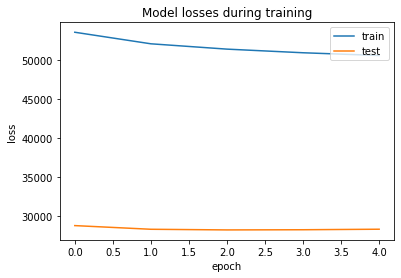

In [15]:
# Plot changes in model loss during training
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

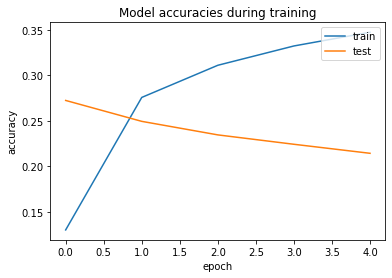

In [16]:
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

As we can see, the model is `overfitted` on the training dataset. It works well for training data, simply because it memorized them. However, the performance on training data is not important. The model should be able to `generalize` to new unseen data.

The overfitting phenomenon is especially strong when models have many parameters. It can be mediated by `model regularization` and use of user and movie features that help the model generalize better to unseen data.

Moreover, The model is re-recommending some of users' already watched movies. These known-positive watches can crowd out test movies out of top K recommendations and reduce the model accuracy for test data. This can be tackled by excluding previously seen movies from test recommendations in a third stage. This approach is relatively common in the recommender systems literature, but we don't follow it in these tutorials. If not recommending past watches is important, we should expect appropriately specified models to learn this behaviour automatically from past user history and contextual information. Additionally, it is often appropriate to recommend the same item multiple times (say, an evergreen TV series or a regularly purchased item).

### Making predictions
To make recommendations, at first, we have to find the representation embedding vectors for all candidates in the corpus and `index` them all for future retrieval.

Then, we can get a `query`, pass it through the query tower and find its representation embedding vector.

Finally, we can calculate the affinity score between the query and all the candidates, sort them and find `k-nearest` candidates to the query. It is called a `brute-force` search and TFRS exposes a layer named `tfrs.layers.factorized_top_k.BruteForce` to do this.

In [17]:
brute_force_layer = tfrs.layers.factorized_top_k.BruteForce(
    movielens_retrieval_model.query_model
)

brute_force_layer.index(
    candidates_corpus_dataset.batch(100).map(
        movielens_retrieval_model.candidate_model
    ),
    candidates_corpus_dataset
)

In [18]:
user_id = '42'
afinity_scores, movie_ids = brute_force_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using BruteForce: {movie_ids[0, :5]}")

Recommendations for user 42 using BruteForce: [b'468' b'1043' b'560' b'944' b'140']


In [19]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    movielens_retrieval_model.query_model
)

scann_layer.index(
    candidates_corpus_dataset.batch(100).map(
        movielens_retrieval_model.candidate_model
    ),
    candidates_corpus_dataset
)

user_id = '42'
afinity_scores, movie_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]}")

Recommendations for user 42 using ScaNN: [b'468' b'966' b'1043' b'1221' b'140']


### Save the model to use in future
To make it possible to serve the Keras model using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving), export it to a `SavedModel` format.

In [20]:
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir:
  retrieval_model_path = os.path.join(tmp_dir, "retrieval_model")


scann_layer.save(
    retrieval_model_path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

INFO:tensorflow:Assets written to: /tmp/tmpj1tgnb8l/retrieval_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpj1tgnb8l/retrieval_model/assets


## Build the Ranking (Scoring) task



In [22]:
class RankingModel(tfrs.models.Model):
  """MovieLens ranking model"""

  def __init__(self, query_model, candidate_model):
    super().__init__()

    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.rating_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ]
    )
    self.ranking_task_layer: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )


  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    candidate_embeddings = self.candidate_model(features["movie_id"])
    rating_predictions = self.rating_model(
        tf.concat(
            [query_embeddings, candidate_embeddings],
            axis=1
        )
        # We could use `tf.keras.layers.Concatenate(axis=1)([x, y])`
    )

    loss = self.ranking_task_layer(
        predictions=rating_predictions,
        labels=features["user_rating"]
    )
    return loss

### Fit the ranking model

In [23]:
movielens_ranking_model = RankingModel(query_model, candidate_model)

optimizer_step_size = 0.1
movielens_ranking_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [24]:
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(8192).cache()
ranking_ratings_testset = ratings_testset.batch(4096).cache()

history = movielens_ranking_model.fit(
    ranking_ratings_trainset,
    validation_data=ranking_ratings_testset,
    validation_freq=1,
    epochs=5
)

Epoch 1/5
10/10 [==============================] - 2s 137ms/step - root_mean_squared_error: 2.7292 - loss: 6.7427 - regularization_loss: 0.0000e+00 - total_loss: 6.7427 - val_root_mean_squared_error: 1.0694 - val_loss: 1.1080 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1080
Epoch 2/5
10/10 [==============================] - 1s 69ms/step - root_mean_squared_error: 1.0666 - loss: 1.1324 - regularization_loss: 0.0000e+00 - total_loss: 1.1324 - val_root_mean_squared_error: 1.0556 - val_loss: 1.0822 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0822
Epoch 3/5
10/10 [==============================] - 1s 69ms/step - root_mean_squared_error: 1.0394 - loss: 1.0736 - regularization_loss: 0.0000e+00 - total_loss: 1.0736 - val_root_mean_squared_error: 1.0142 - val_loss: 0.9957 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9957
Epoch 4/5
10/10 [==============================] - 1s 69ms/step - root_mean_squared_error: 1.0131 - loss: 1.0225 - regularization_loss:

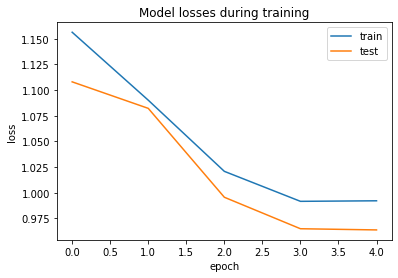

In [25]:
# Plot changes in model loss during training
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()